In [4]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf
import sys
sys.path.append("../") 
import CustomGenerator
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [5]:
import importlib
importlib.reload(CustomGenerator)
from CustomGenerator import ReturnsDataGen, CodeBookDataGen

In [8]:
import os 
print(os.getcwd())

/Users/danielrzapatas/Documents/AI/Dissertation/repositories/AI_Dissertation/drafts_notebooks


In [9]:
# Load data
data = np.load('/Users/danielrzapatas/Documents/AI/Dissertation/repositories/AI_Dissertation/master_data/data.npy')
train_batches = data.shape[0] # N hereafter. Number of training images in database.
length = data.shape[1] 
stocks = data.shape[2]
print('Number of training batches: ', train_batches)
print('Length of each batch: ', length)
print('Number of stocks: ', stocks)
data.shape

Number of training batches:  189
Length of each batch:  250
Number of stocks:  363


(189, 250, 363)

In [10]:
data_gen = ReturnsDataGen(data)

Number of training batches:  189
Length of each batch:  250
Number of stocks:  363


In [11]:
type(data[0,0,0])

numpy.float64

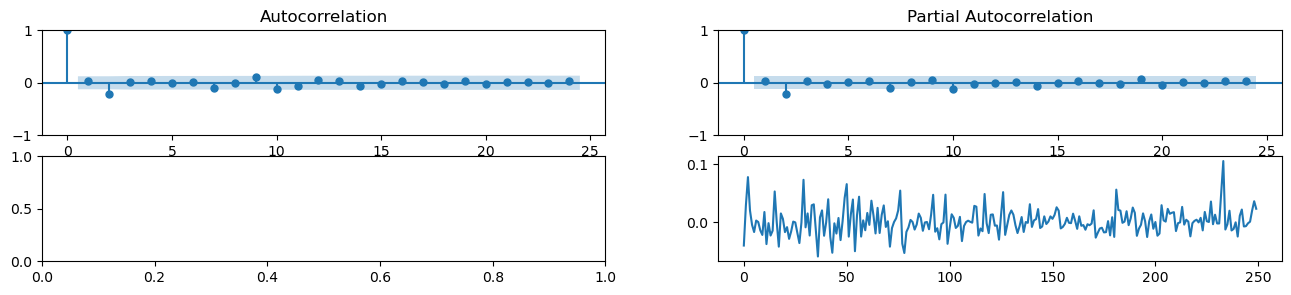

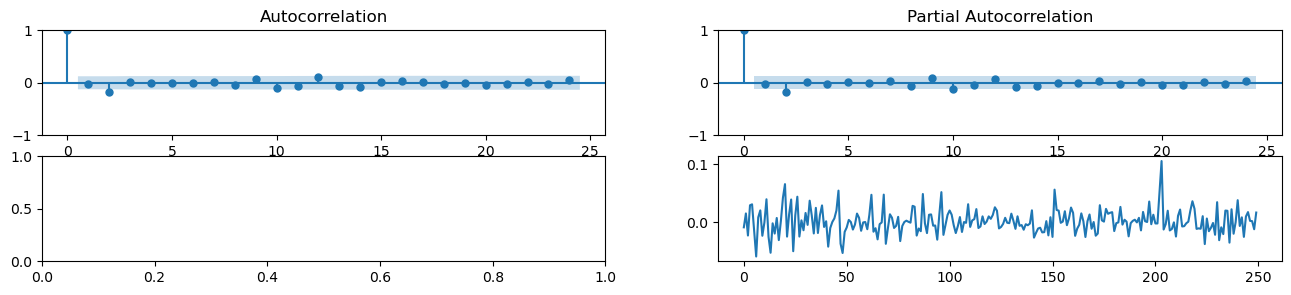

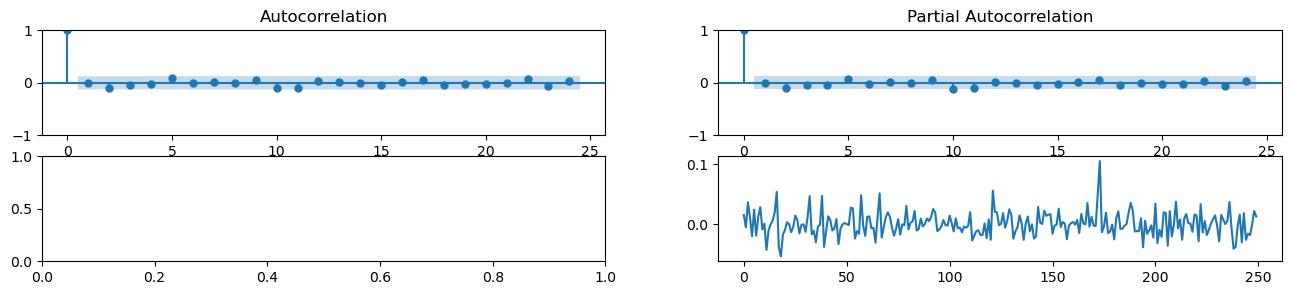

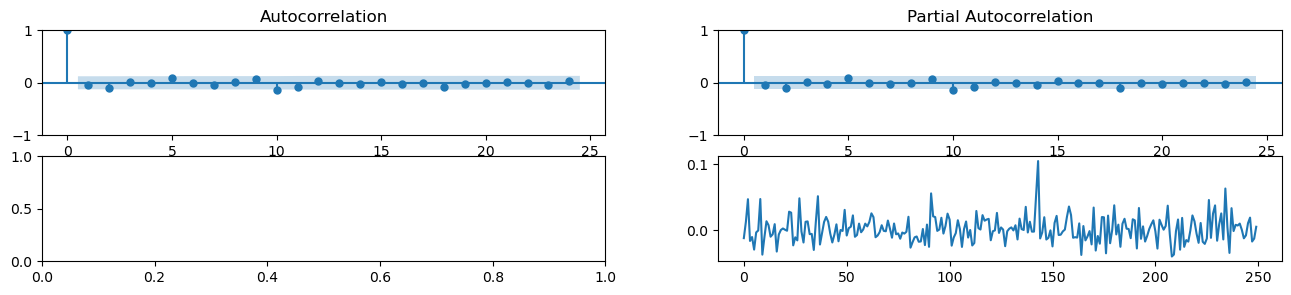

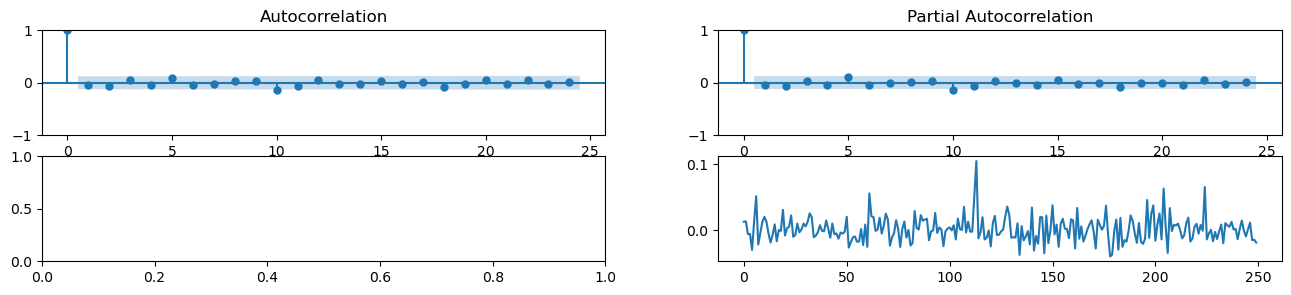

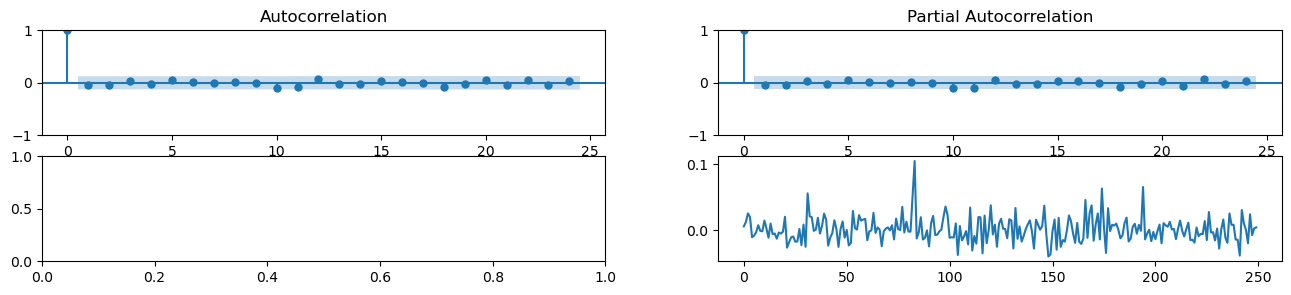

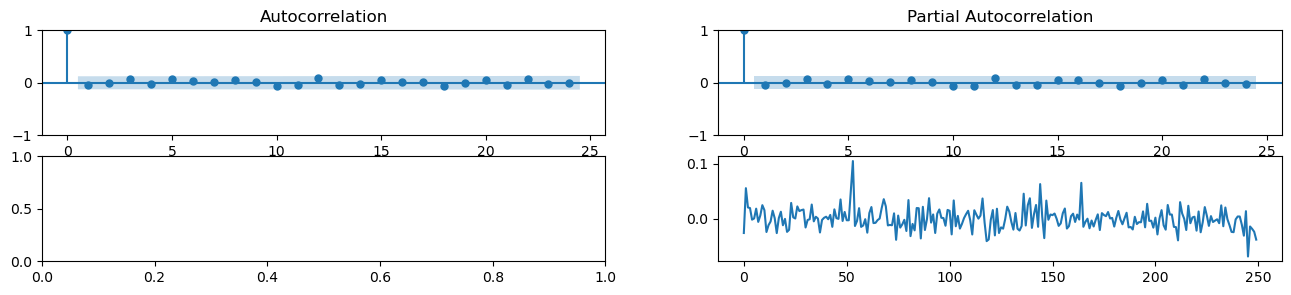

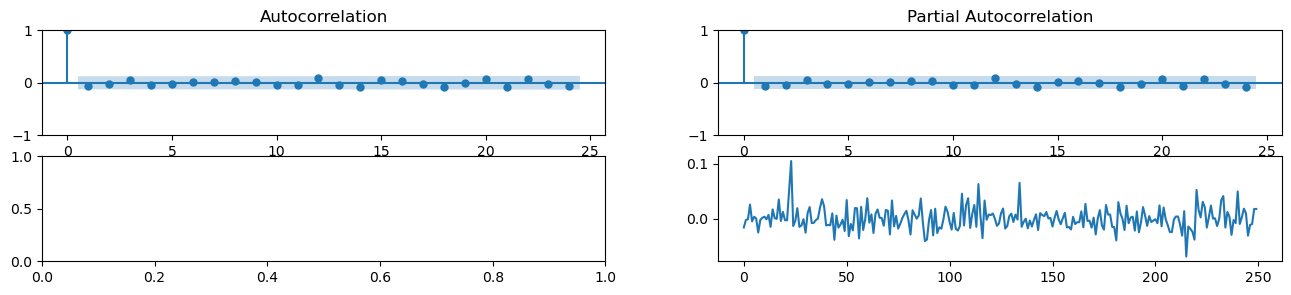

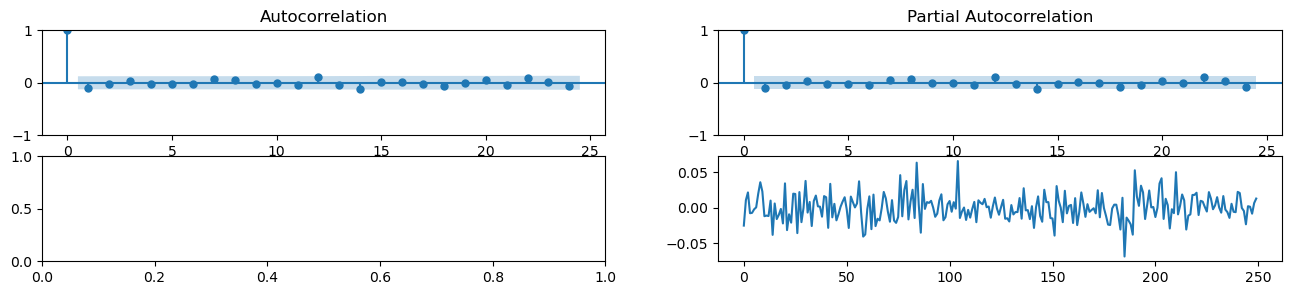

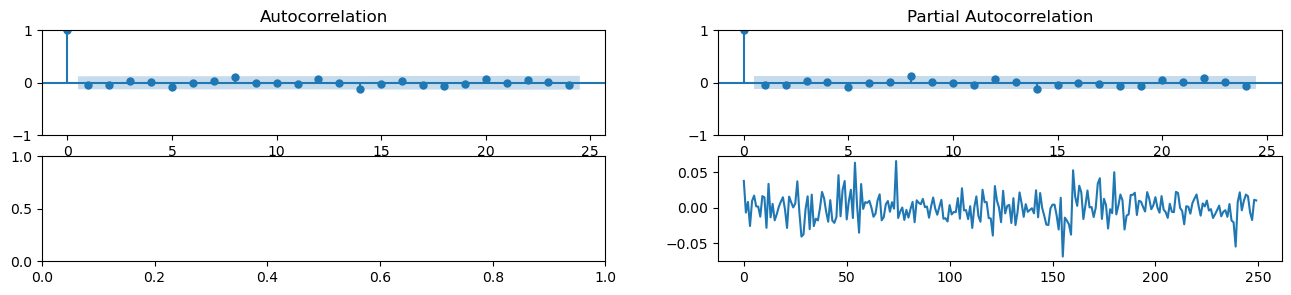

In [278]:
# series = encoding_indices.numpy()
# fig, axes = plt.subplots(2,2,figsize=(16,3), dpi= 100)
# plt.plot(series)
# plot_acf( series,  ax=axes[0,0])
# plot_pacf(series,  ax=axes[0, 1])
# plt.show()
for i in range(10):
    series = data[i,:,0]
    fig, axes = plt.subplots(2,2,figsize=(16,3), dpi= 100)
    plt.plot(series)
    plot_acf( series,  ax=axes[0,0])
    plot_pacf(series,  ax=axes[0, 1])
    plt.show()

    # plt.plot(data[i,:,0])
    # plt.show()
# x = data[0,:,0]
# x = np.expand_dims(x, axis=1)
# x.shape

## Modeling

In [14]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, latent_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = latent_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

In [15]:
def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(250, 1), name='encoder_input')
    x = layers.Conv1D(32, 3, activation="relu", strides=2, padding="valid", name='conv1d_1')(
        encoder_inputs
    )
    x = layers.Conv1D(64, 3, activation="relu", strides=2, padding="same", name='conv1d_2')(x)
    encoder_outputs = layers.Conv1D(latent_dim, 1, padding="same", name='conv1d_3')(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:], name='decoder_input')

    x = layers.Conv1DTranspose(64, 1, activation="relu",  padding="valid", name='conv1d_tr_1')(
        latent_inputs
    )
    x = layers.Conv1DTranspose(32, 3, activation="relu", strides=2, padding="same",output_padding =1, name='conv1d_tr_2')(x)
    decoder_outputs = layers.Conv1DTranspose(1, 3, strides=2,padding="valid",output_padding =1, name='conv1d_tr_3')(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [16]:
encoder = get_encoder()
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 250, 1)]          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 124, 32)           128       
                                                                 
 conv1d_2 (Conv1D)           (None, 62, 64)            6208      
                                                                 
 conv1d_3 (Conv1D)           (None, 62, 16)            1040      
                                                                 
Total params: 7376 (28.81 KB)
Trainable params: 7376 (28.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-08-01 15:20:24.806233: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-08-01 15:20:24.806290: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-01 15:20:24.806299: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-01 15:20:24.806572: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-01 15:20:24.806598: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
decoder = get_decoder()
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 62, 16)]          0         
                                                                 
 conv1d_tr_1 (Conv1DTranspo  (None, 62, 64)            1088      
 se)                                                             
                                                                 
 conv1d_tr_2 (Conv1DTranspo  (None, 124, 32)           6176      
 se)                                                             
                                                                 
 conv1d_tr_3 (Conv1DTranspo  (None, 250, 1)            97        
 se)                                                             
                                                                 
Total params: 7361 (28.75 KB)
Trainable params: 7361 (28.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________

In [18]:
def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(250, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae(16, 32).summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 1)]          0         
                                                                 
 encoder (Functional)        (None, 62, 16)            7376      
                                                                 
 vector_quantizer (VectorQu  (None, 62, 16)            512       
 antizer)                                                        
                                                                 
 decoder (Functional)        (None, 250, 1)            7361      
                                                                 
Total params: 15249 (59.57 KB)
Trainable params: 15249 (59.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
@keras.saving.register_keras_serializable()
class VQVAETrainer(keras.models.Model):
    def __init__(self, latent_dim=32, num_embeddings=128, **kwargs):
        super().__init__(**kwargs)

        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)
            print(reconstructions.shape)
            print(x.shape)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) 
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

In [26]:
latent_dim = 16
num_embeddings = 128

In [27]:
vqvae_trainer = VQVAETrainer(latent_dim=latent_dim, num_embeddings=num_embeddings)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(data_gen, epochs=30)

Epoch 1/30
(None, None, 1)
(None, None, None)
(None, None, 1)
(None, None, None)


2023-08-01 15:35:54.559188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 65/189 [=========>....................] - ETA: 2s - loss: 3.4029e-04 - reconstruction_loss: 2.3967e-04 - vqvae_loss: 9.8884e-05

KeyboardInterrupt: 

In [55]:
vqvae_trainer.save('vqvae_trainer_18072023.keras')

In [ ]:
# vqvae_trainer2 = keras.models.load_model('vqvae_trainer_18072023.keras')

In [382]:
vqvae_trainer.history.history.keys()

dict_keys(['loss', 'reconstruction_loss', 'vqvae_loss'])

In [383]:
loss = vqvae_trainer.history.history['loss']
reconstruction_loss= vqvae_trainer.history.history['reconstruction_loss']
vqvae_loss = vqvae_trainer.history.history['vqvae_loss']


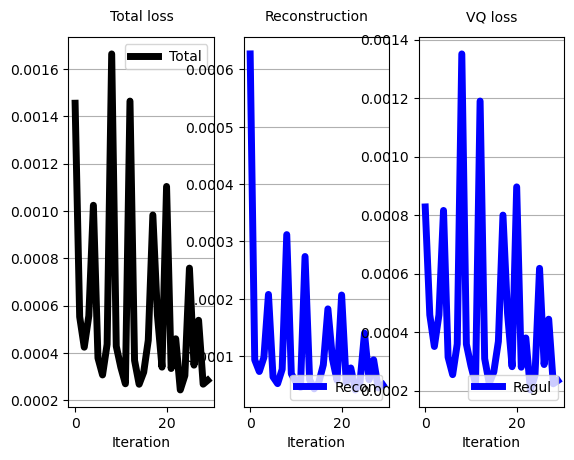

In [384]:
fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

x_points = np.arange(0, len(loss), 1)
axes[0].set_title("Total loss", fontsize=10, y=1.022)
axes[0].plot(x_points, loss, color="black", label="Total", linewidth=5)
axes[0].yaxis.grid(True, zorder=0)
axes[0].set_xlabel('Iteration', fontsize=10)
axes[0].legend(loc='upper right')

axes[1].set_title("Reconstruction", fontsize=10, y=1.022)
axes[1].plot(x_points, reconstruction_loss, color="blue", label="Recon", linewidth=5)
axes[1].yaxis.grid(True, zorder=0)
axes[1].set_xlabel('Iteration', fontsize=10)
axes[1].legend(loc='lower right')

axes[2].set_title("VQ loss", fontsize=10, y=1.022)
axes[2].plot(x_points, vqvae_loss, color="blue", label="Regul", linewidth=5)
axes[2].yaxis.grid(True, zorder=0)
axes[2].set_xlabel('Iteration', fontsize=10)
axes[2].legend(loc='lower right')

plt.show()      

In [385]:
trained_vqvae_model = vqvae_trainer.vqvae

## Reconstruction

In [386]:
def plot_rec_series(x_hat_series, x_series):
    fig, axes = plt.subplots(3,1, figsize=(30,20), dpi= 50)
    axes[0].plot(x_series, label='original')
    axes[0].plot(x_hat_series, label='reconstructed')
    axes[0].legend()
    axes[1].plot(x_hat_series, label='reconstructed', color='darkorange')
    axes[1].legend()
    axes[2].plot(x_series, label='original')
    axes[2].legend()
    plt.show()

(250, 363)
(363, 250)
(363, 250, 1)


2023-07-26 16:05:36.251063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 17ms/step
(363, 250, 1)


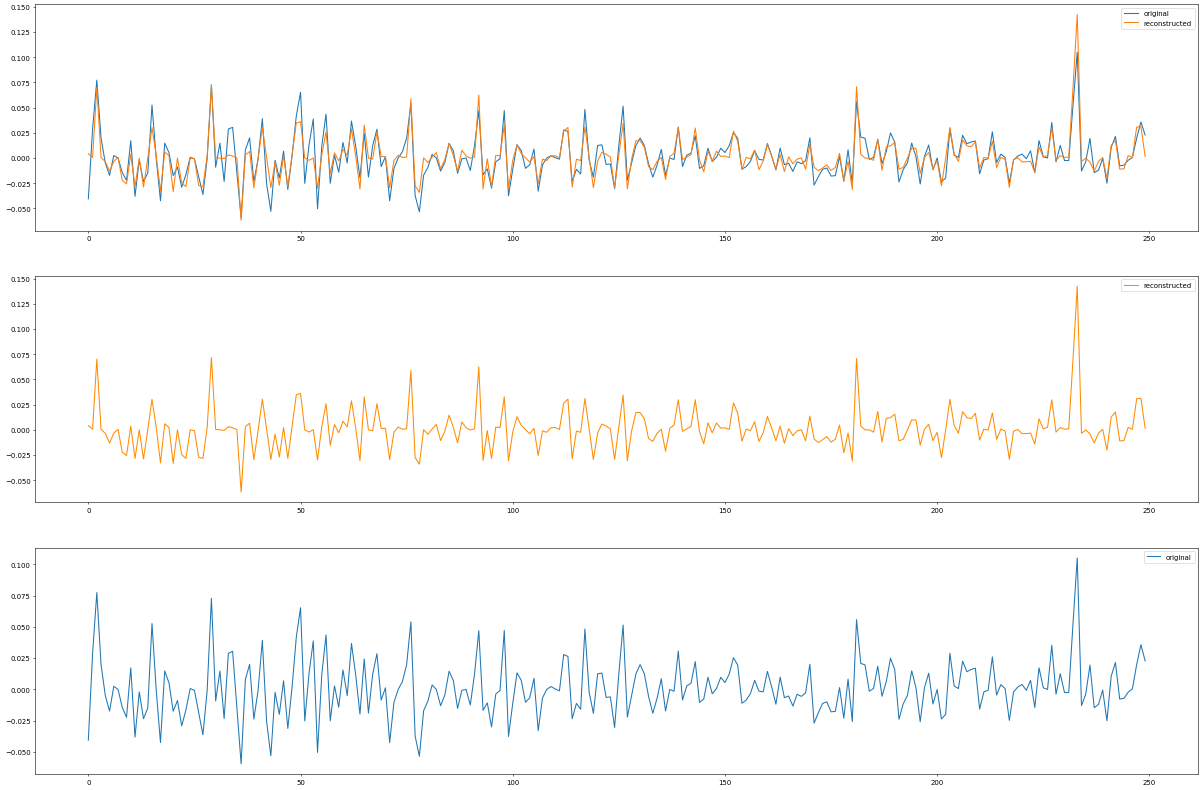

In [387]:
series_idx = 0 
batch_idx = 0
batch= data[batch_idx]
print(batch.shape)
batch= np.transpose(batch)
print(batch.shape)
batch= np.expand_dims(batch, axis=2)
print(batch.shape)
trained_vqvae_model = vqvae_trainer.vqvae
x_hat = trained_vqvae_model.predict(batch)
print(x_hat.shape)

x_hat_series = x_hat[series_idx,:]
x_series = batch[series_idx,:]

plot_rec_series(x_hat_series, x_series)

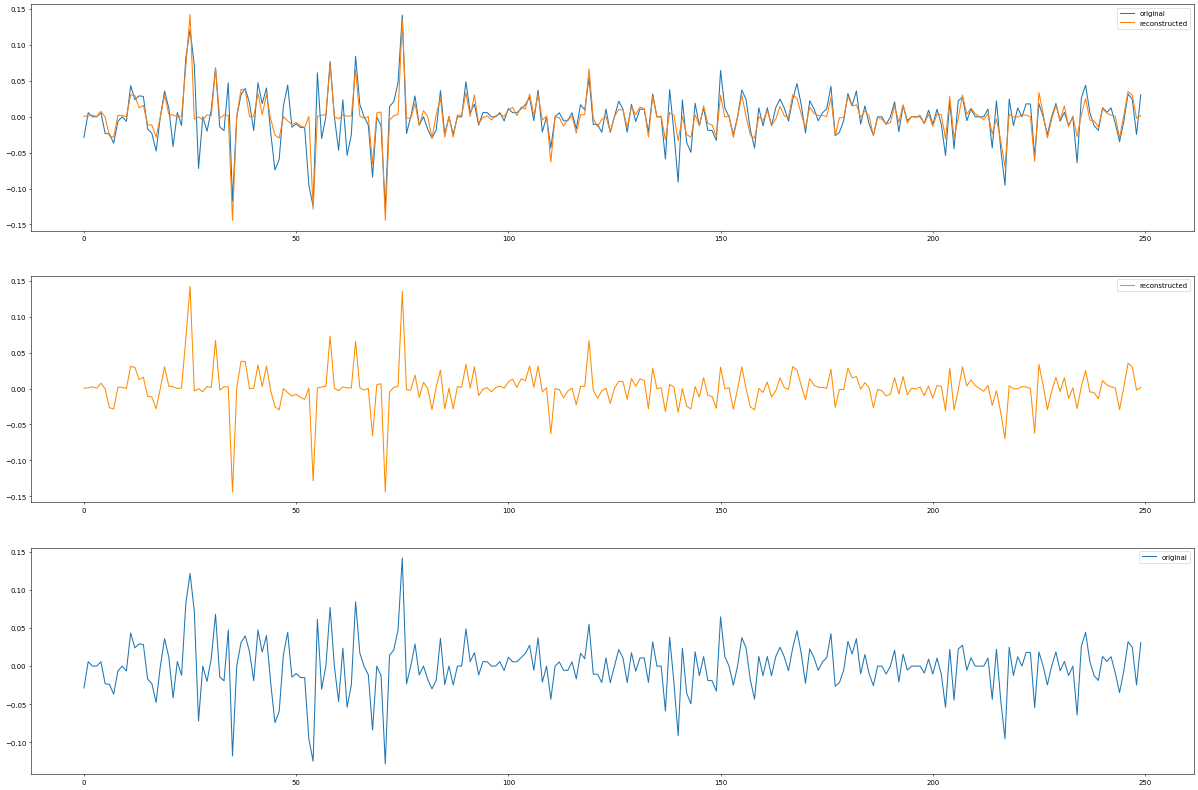

In [388]:
series_idx = 30
x_hat_series = x_hat[series_idx,:]
x_series = batch[series_idx,:]

plot_rec_series(x_hat_series, x_series)

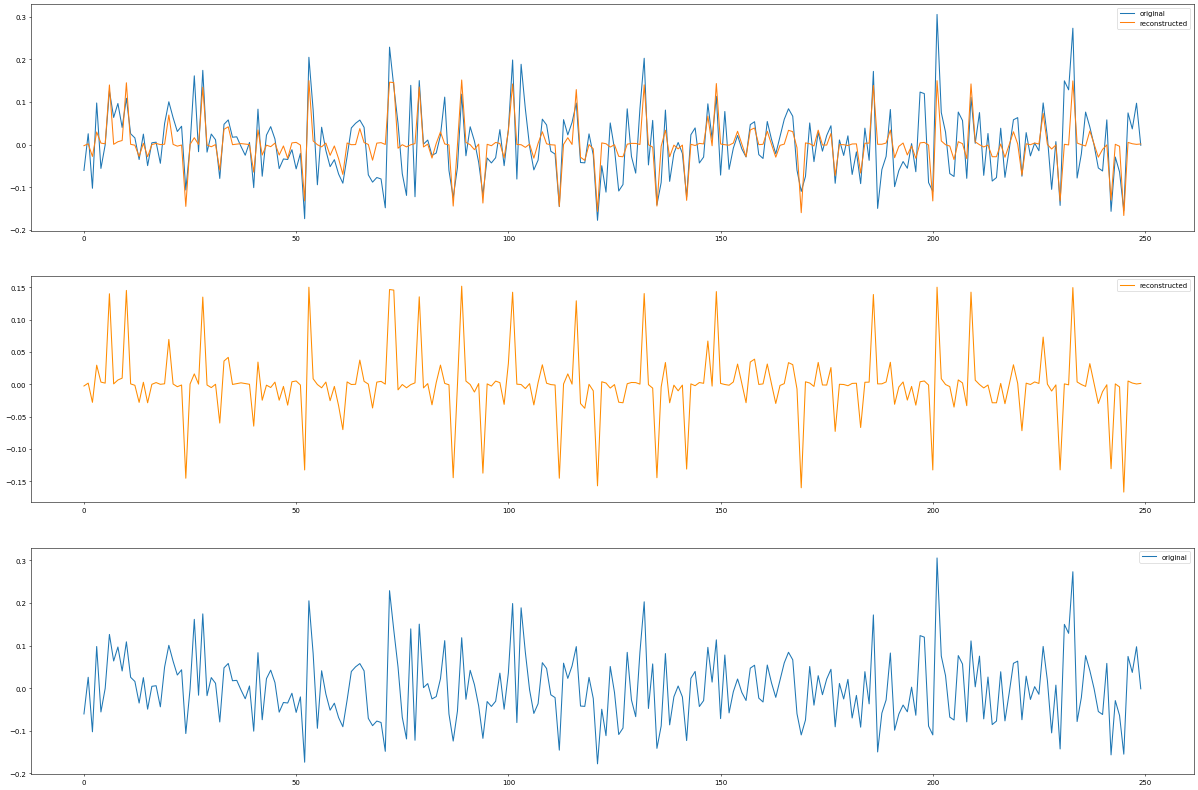

In [390]:
series_idx = 300
x_hat_series = x_hat[series_idx,:]
x_series = batch[series_idx,:]

plot_rec_series(x_hat_series, x_series)

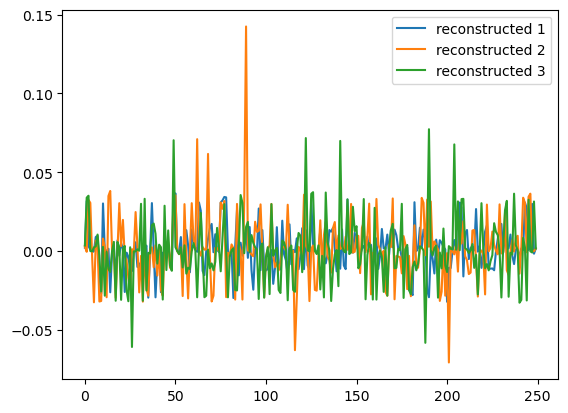

In [391]:
plt.plot(x_hat[20, :], label='reconstructed 1')
plt.plot(x_hat[10, :], label='reconstructed 2')
plt.plot(x_hat[100, :], label='reconstructed 3')
# plt.plot(x_hat[0, :], label='generated 5')
# plt.plot(x_hat[40, :], label='generated 6')
plt.legend()
plt.show()

In [392]:
batch= data[0]
print(batch.shape)
batch= np.transpose(batch)
print(batch.shape)
batch= np.expand_dims(batch, axis=2)
print(batch.shape)


(250, 363)
(363, 250)
(363, 250, 1)


In [393]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(batch)
print(encoded_outputs.shape)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
print(flat_enc_outputs.shape)
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

# for i in range(10):
#     plt.subplot(1, 2, 1)
#     plt.plot(batch[i] )
#     plt.title("Original")
#     # plt.axis("off")

#     plt.subplot(1, 2, 2)
#     plt.plot(codebook_indices[i])
#     plt.title("Code")
#     # plt.axis("off")
#     plt.show()

12/12 [==============================] - 0s 6ms/step


2023-07-26 16:07:49.269007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(363, 62, 16)
(22506, 16)


## Exploring the embedings

In [394]:
codebook_indices.shape


(363, 62)

In [395]:
embeddings = quantizer.embeddings
print(embeddings.shape)

(16, 128)


In [396]:
batch.shape

(363, 250, 1)

In [397]:
sample = np.expand_dims(batch[0],axis=0)

In [398]:
sample = np.expand_dims(batch[0],axis=0)
print(f'sample dim: {sample.shape}' )
encoded_outputs = encoder.predict(sample)

print(f'Encode output dim: {encoded_outputs.shape}')
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
print(f'Encode output dim flat: {flat_enc_outputs.shape}')
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
print(f'Codebook dim: {codebook_indices.shape}')
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
print(f'Codebook dim: {codebook_indices.shape}')


sample dim: (1, 250, 1)
1/1 [==============================] - 0s 45ms/step
Encode output dim: (1, 62, 16)
Encode output dim flat: (62, 16)
Codebook dim: (62,)
Codebook dim: (1, 62)


In [399]:
flattened_inputs = flat_enc_outputs
print(f'Flattened input dim: {flattened_inputs.shape}')
print(f'Embeddings dim: {embeddings.shape}')
similarity = tf.matmul(flattened_inputs, embeddings)
print(f'Similarity dim: {similarity.shape}')
distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(embeddings ** 2, axis=0)
            - 2 * similarity
        )
print(f'Distances dim: {distances.shape}')
encoding_indices = tf.argmin(distances, axis=1)
print(f'Encoding indices dim: {encoding_indices.shape}')

Flattened input dim: (62, 16)
Embeddings dim: (16, 128)
Similarity dim: (62, 128)
Distances dim: (62, 128)
Encoding indices dim: (62,)


A embedding can be choose multiple times, and order of embeddings is also important for reconstruction.

In [400]:
encoding_indices

<tf.Tensor: shape=(62,), dtype=int64, numpy=
array([100, 118,  41,  81, 104, 106, 106,  60,  68,  69,  39,  41,  82,
       113,  78,  91,  15,  69,  48, 102,  19,  49,  48,  41, 109,  13,
        53, 124,  20,  39,  43, 109,  65, 118, 107, 107,  78, 124,  38,
         3,  62,  67,  59,  16,  22,  60,  86, 126, 127,  19,  81,  32,
        38,  38, 121,  94, 107,  48,  17, 118, 126,  42])>

In [401]:
num_embeddings = embeddings.shape[1]
# Quantization.
encodings = tf.one_hot(encoding_indices, num_embeddings)
print(f'Encodings dim: {encodings.shape}')
quantized = tf.matmul(encodings, embeddings, transpose_b=True)
print(f'Quantized dim: {quantized.shape}')
        # Reshape the quantized values back to the original input shape
quantized = tf.reshape(quantized, flattened_inputs.shape)
print(f'Quantized dim: {quantized.shape}')


Encodings dim: (62, 128)
Quantized dim: (62, 16)
Quantized dim: (62, 16)


### PLots

In [402]:
embeddings[:,0]

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([-0.0188207 , -0.0291773 ,  0.02877505, -0.00092594,  0.04043931,
       -0.04961465, -0.02862685, -0.04265636, -0.031902  , -0.01354044,
       -0.0332356 ,  0.00639552, -0.02317815,  0.02992752,  0.04574614,
       -0.00621781], dtype=float32)>

Embeddings dim latent dim X Num embeddings : (16, 128)


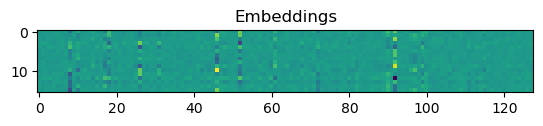

In [403]:

plt.imshow(embeddings)
plt.title("Embeddings")
print(f'Embeddings dim latent dim X Num embeddings : {embeddings.shape}')
plt.show()


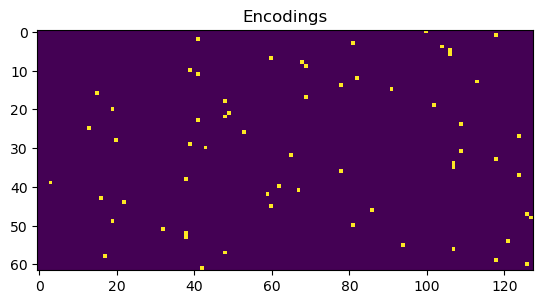

Encodings dim #vectors X Num embeddings : (62, 128)


In [404]:


plt.imshow(encodings)
plt.title("Encodings")
plt.show()
print(f'Encodings dim #vectors X Num embeddings : {encodings.shape}')

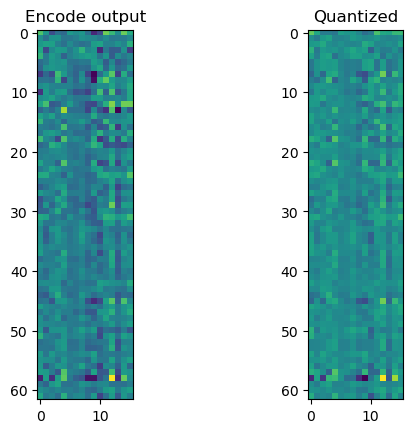

Encode output dim: (1, 62, 16)
Quantized dim: (62, 16)


In [405]:
plt.subplot(1, 2, 1)
plt.imshow(flattened_inputs)
plt.title("Encode output")
# plt.axis("off")


plt.subplot(1, 2, 2)
plt.imshow(quantized)
plt.title("Quantized")
# plt.axis("off")
plt.show()

print(f'Encode output dim: {encoded_outputs.shape}')
print(f'Quantized dim: {quantized.shape}')

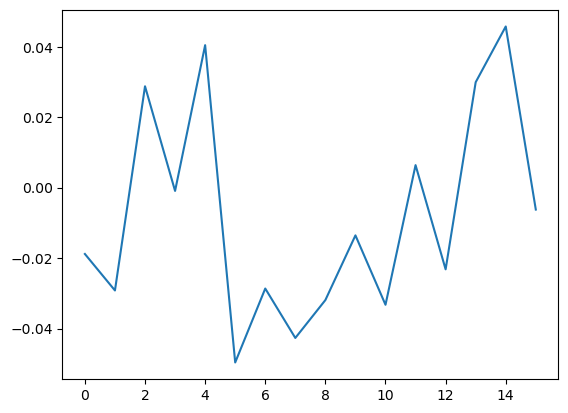

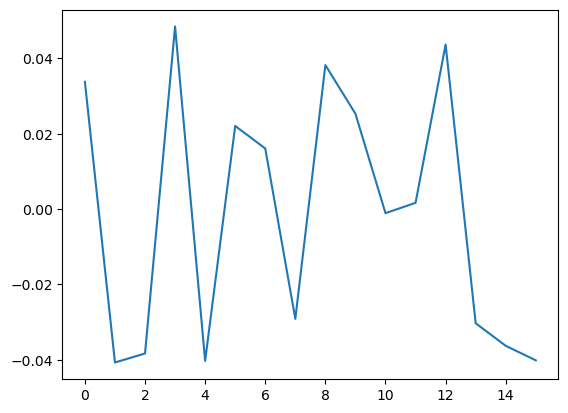

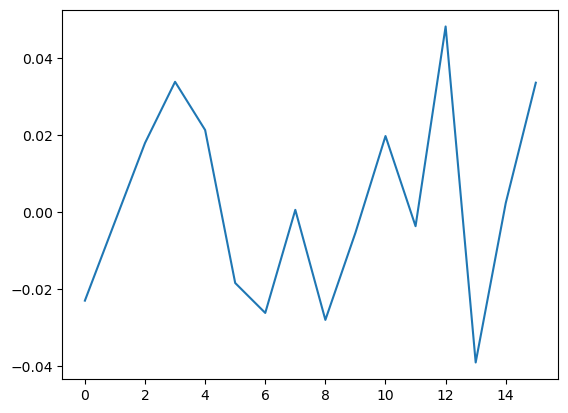

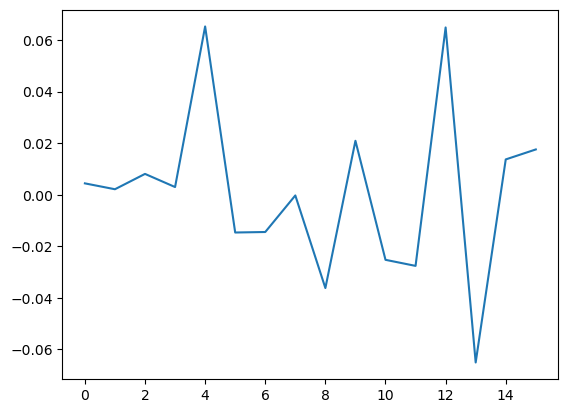

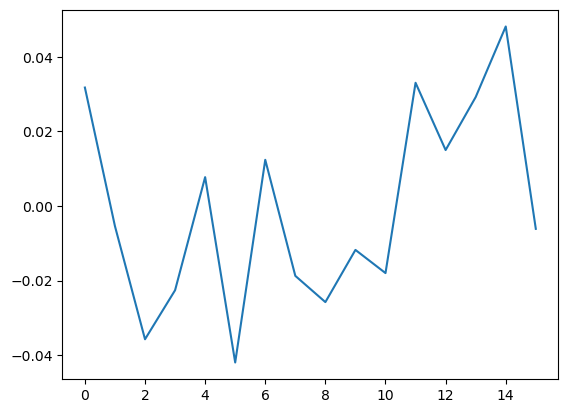

In [406]:
for i in range(5):
    plt.plot(embeddings[:, i])
    plt.show()


## Are the embedding codings an autoregressive time series ?? 

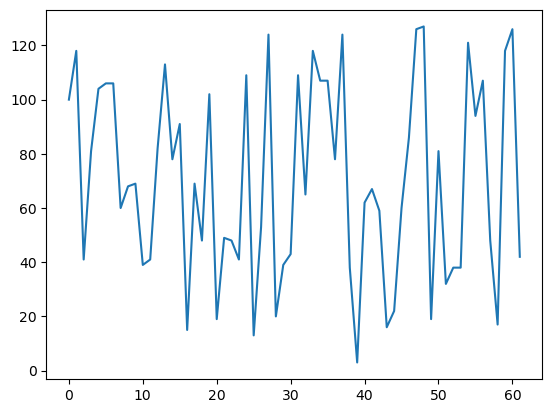

In [407]:
plt.plot(encoding_indices)

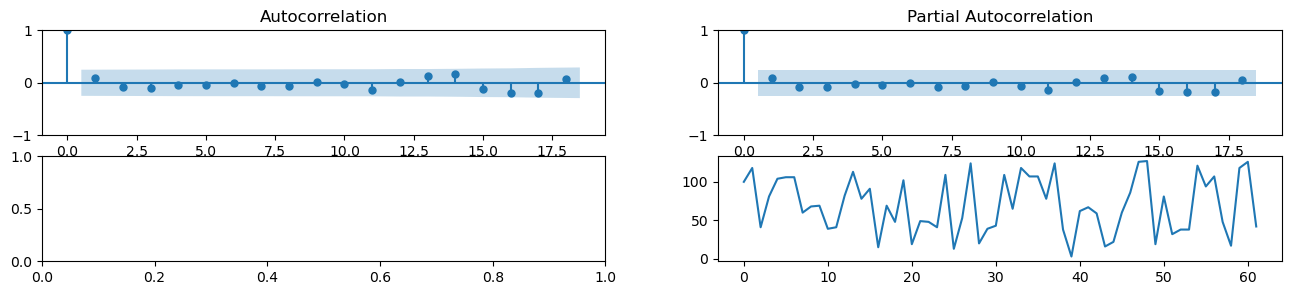

In [409]:
series = encoding_indices.numpy()
fig, axes = plt.subplots(2,2,figsize=(16,3), dpi= 100)
plt.plot(series, label='encoding indices')
plot_acf( series,  ax=axes[0,0])
plot_pacf(series,  ax=axes[0, 1])
plt.show()

## Reconstruct a full time series from embbedings 

In [312]:
codebook_indices_all = np.empty((train_batches, stocks , 62 ))
codebook_indices_all.shape

(189, 363, 62)

In [313]:
for i, batch in enumerate(data): 
    # b= np.empty((stocks , length ))
    batch= np.transpose(batch)
    
    batch= np.expand_dims(batch, axis=2)
    encoded_outputs_all = encoder.predict(batch)
    flat_enc_outputs = encoded_outputs_all.reshape(-1, encoded_outputs_all.shape[-1])

    codebook_indices = quantizer.get_code_indices(flat_enc_outputs)

    codebook_indices_all[i,:, :] = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
    

12/12 [==============================] - 0s 2ms/step


In [314]:
codebook_indices_all.shape

(189, 363, 62)

In [315]:
codebook_indices_all[:,0,:].shape

(189, 62)

In [ ]:
series_idx = 0 
stock_codes = codebook_indices_all[:,0,:]


##  Sampling no model

(1, 62)
Encodings dim: (1, 62, 128)
Quantized dim: (1, 62, 16)
Quantized dim: (62, 16)
Quantized dim: (1, 62, 16)
1/1 [==============================] - 0s 12ms/step
Generation dim: (1, 250, 1)


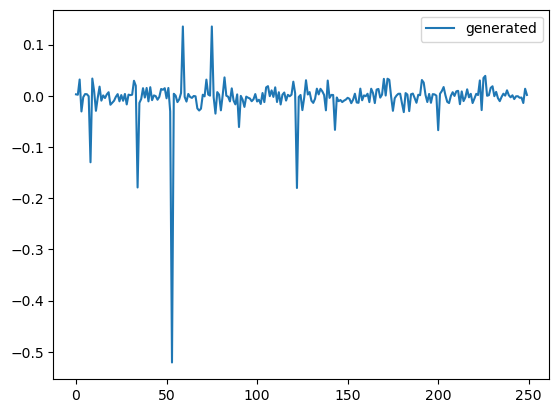

In [442]:
import random
x = [random.randint(1,num_embeddings) for x in range(62)]
# x = [4]*10 + [32]*10 +[20]*10 + [40]*32
x = np.array(x)
x = np.expand_dims(x, axis=0)
print(x.shape)
# Quantization.
encodings = tf.one_hot(x, num_embeddings)
print(f'Encodings dim: {encodings.shape}')
quantized = tf.matmul(encodings, embeddings, transpose_b=True)
print(f'Quantized dim: {quantized.shape}')
        # Reshape the quantized values back to the original input shape
quantized = tf.reshape(quantized, flattened_inputs.shape)
print(f'Quantized dim: {quantized.shape}')
quantized = np.expand_dims(quantized,axis=0)
print(f'Quantized dim: {quantized.shape}')
decoder = vqvae_trainer.vqvae.get_layer("decoder")
generation = decoder.predict(quantized)
print(f'Generation dim: {generation.shape}')
plt.plot(generation[0], label='generated')
plt.legend()
plt.show()

## Sampling with Pixel CNN

In [411]:
batch= data[0]
print(batch.shape)
batch= np.transpose(batch)
print(batch.shape)
batch= np.expand_dims(batch, axis=2)
print(batch.shape)

encoded_outputs = encoder.predict(batch)
print(encoded_outputs.shape)

(250, 363)
(363, 250)
(363, 250, 1)
12/12 [==============================] - 0s 2ms/step
(363, 62, 16)


In [412]:
num_residual_blocks = 1
num_pixelcnn_layers = 1
pixelcnn_input_shape = encoded_outputs.shape[1:-1]
print(f"Input shape of the PixelCNN: {pixelcnn_input_shape}")

Input shape of the PixelCNN: (62,)


In [413]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super().__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv1D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = keras.layers.Conv1D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv1D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])


In [414]:
pixelcnn_inputs = keras.Input(shape=pixelcnn_input_shape, dtype=tf.int32)
print(f"PixelCNN input shape: {pixelcnn_inputs.shape}")
ohe = tf.one_hot(pixelcnn_inputs, vqvae_trainer.num_embeddings)
print(f"OHE shape: {ohe.shape}")
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=15, activation="relu", padding="same"
)(ohe)
print(f"PixelCNN output shape: {x.shape}")

PixelCNN input shape: (None, 62)
OHE shape: (None, 62, 128)
PixelCNN output shape: (None, 62, 128)


In [415]:
ohe

<KerasTensor: shape=(None, 62, 128) dtype=float32 (created by layer 'tf.one_hot_17')>

In [416]:


pixelcnn_inputs = keras.Input(shape=pixelcnn_input_shape, dtype=tf.int32)
ohe = tf.one_hot(pixelcnn_inputs, vqvae_trainer.num_embeddings)
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=15, activation="relu", padding="same"
)(ohe)

for _ in range(num_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(num_pixelcnn_layers):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv1D(
    filters=vqvae_trainer.num_embeddings, kernel_size=1, strides=1, padding="valid"
)(x)

pixel_cnn = keras.Model(pixelcnn_inputs, out, name="pixel_cnn")
pixel_cnn.summary()

Model: "pixel_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 62)]              0         
                                                                 
 tf.one_hot_18 (TFOpLambda)  (None, 62, 128)           0         
                                                                 
 pixel_conv_layer_47 (Pixel  (None, 62, 128)           245888    
 ConvLayer)                                                      
                                                                 
 residual_block_14 (Residua  (None, 62, 128)           49472     
 lBlock)                                                         
                                                                 
 pixel_conv_layer_49 (Pixel  (None, 62, 128)           16512     
 ConvLayer)                                                      
                                                         

In [417]:
batch= data[0]
print(batch.shape)
batch= np.transpose(batch)
print(batch.shape)
batch= np.expand_dims(batch, axis=2)
print(batch.shape)

(250, 363)
(363, 250)
(363, 250, 1)


In [418]:
# Generate the codebook indices.
encoded_outputs = encoder.predict(batch)
print(encoded_outputs.shape)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
print(flat_enc_outputs.shape)
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
print(codebook_indices.shape)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
print(f"Shape of the training data for PixelCNN: {codebook_indices.shape}")

12/12 [==============================] - 0s 1ms/step
(363, 62, 16)
(22506, 16)
(22506,)
Shape of the training data for PixelCNN: (363, 62)


In [419]:
codebook_indices.shape

(363, 62)

codebook_indices_all = np.empty((train_batches, stocks , 62 ))
codebook_indices_all.shape

for i, batch in enumerate(data): 
    # b= np.empty((stocks , length ))
    batch= np.transpose(batch)
    
    batch= np.expand_dims(batch, axis=2)
    encoded_outputs_all = encoder.predict(batch)
    flat_enc_outputs = encoded_outputs_all.reshape(-1, encoded_outputs_all.shape[-1])

    codebook_indices = quantizer.get_code_indices(flat_enc_outputs)

    codebook_indices_all[i,:, :] = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
    

codebook_indices_all.shape

codebook_indices_all[0].shape

In [420]:
codebook_indices.shape

(363, 62)

codebook_indices_all = codebook_indices_all.reshape(-1, codebook_indices_all.shape[-1])
print(f"Shape of the training data for PixelCNN: {codebook_indices_all.shape}")

In [421]:
codebook_gen = CodeBookDataGen(codebook_indices_all)

Number of training batches:  189
Number of stocks:  363
Number of latent variables:  62


In [422]:
codebook_indices[0]

array([100, 118,  41,  81, 104, 106, 106,  60,  68,  69,  39,  41,  82,
       113,  78,  91,  15,  69,  48, 102,  19,  49,  48,  41, 109,  13,
        53, 124,  20,  39,  43, 109,  65, 118, 107, 107,  78, 124,  38,
         3,  62,  67,  59,  16,  22,  60,  86, 126, 127,  19,  81,  32,
        38,  38, 121,  94, 107,  48,  17, 118, 126,  42])

In [423]:
pixel_cnn.compile(
    optimizer=keras.optimizers.legacy.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
pixel_cnn.fit(
    # codebook_gen,
    x = codebook_indices,
    y = codebook_indices,
    batch_size=128,
    epochs=10,
    validation_split=0.3
    )

Epoch 1/10


2023-07-26 16:08:56.298682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 480ms/step - loss: 4.8516 - accuracy: 0.0085 - val_loss: 4.8503 - val_accuracy: 0.0099
Epoch 2/10


2023-07-26 16:08:57.198767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 110ms/step - loss: 4.8482 - accuracy: 0.0133 - val_loss: 4.8474 - val_accuracy: 0.0144
Epoch 3/10
2/2 [==============================] - 0s 67ms/step - loss: 4.8448 - accuracy: 0.0186 - val_loss: 4.8444 - val_accuracy: 0.0181
Epoch 4/10
2/2 [==============================] - 0s 70ms/step - loss: 4.8413 - accuracy: 0.0240 - val_loss: 4.8410 - val_accuracy: 0.0235
Epoch 5/10
2/2 [==============================] - 0s 57ms/step - loss: 4.8373 - accuracy: 0.0291 - val_loss: 4.8372 - val_accuracy: 0.0271
Epoch 6/10
2/2 [==============================] - 0s 81ms/step - loss: 4.8330 - accuracy: 0.0311 - val_loss: 4.8329 - val_accuracy: 0.0287
Epoch 7/10
2/2 [==============================] - 0s 52ms/step - loss: 4.8280 - accuracy: 0.0324 - val_loss: 4.8279 - val_accuracy: 0.0284
Epoch 8/10
2/2 [==============================] - 0s 67ms/step - loss: 4.8223 - accuracy: 0.0321 - val_loss: 4.8220 - val_accuracy: 0.0275
Epoch 9/10
2/2 [=====================

In [424]:
# Create a mini sampler model.
inputs = layers.Input(shape=pixel_cnn.input_shape[1:])
print(inputs.shape)
outputs = pixel_cnn(inputs, training=False)
print(outputs.shape)

(None, 62)
(None, 62, 128)


In [425]:

categorical_layer = tfp.layers.DistributionLambda(tfp.distributions.Categorical)
outputs = categorical_layer(outputs)
print(outputs.shape)
sampler = keras.Model(inputs, outputs)
print(sampler.summary())

(None, 62)
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 62)]              0         
                                                                 
 pixel_cnn (Functional)      (None, 62, 128)           328384    
                                                                 
 distribution_lambda_7 (Dis  ((None, 62),              0         
 tributionLambda)             (None, 62))                        
                                                                 
Total params: 328384 (1.25 MB)
Trainable params: 328384 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [426]:
# Create an empty array of priors.
batch_sample = 10
priors = np.zeros(shape=(batch_sample,) + (pixel_cnn.input_shape)[1:])
print(f"Prior shape: {priors.shape}")
batch_sample, rows = priors.shape


Prior shape: (10, 62)


In [427]:
priors[0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [428]:
probs = sampler.predict(priors)
print(probs.shape)

probs[0, :]

1/1 [==============================] - 0s 233ms/step
(10, 62)


2023-07-26 16:09:04.557224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([124,  91,  45,  85,  19, 115,  97, 112,  33,  53,  50, 121,   3,
       102,  25,  45,  58,  37,  28, 110,  26,  84,  72,  11,  53,  42,
        11,  38, 103,   9, 126,  45,  79,  36,  49,  76,  20,  10,  80,
        71,  54, 116,  18,  65, 100,  15,  85,  68,  65, 100, 127,  88,
       116,   8,  26, 117,  99,  63,  94,  55,  81,  21], dtype=int32)

In [429]:

# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in range(rows):

    # Feed the whole array and retrieving the pixel value probabilities for the next
    # pixel.
    print(f'Row: {row}')

    # print(priors[0, row:-1], priors[0, row:-1].shape)
    probs = sampler.predict(priors)
    # Use the probabilities to pick pixel values and append the values to the priors.
    priors[:, row] = probs[:, row]
    print('Prior',priors[0, :row], priors[0, :row].shape )
    # print('Prior',priors[0, row:-1], priors[0, row:-1].shape )
    print('Probs',probs[0, :row+1], probs[0, :row-1].shape )
    # print('Probs',probs[0, row:-1], probs[0, row:-1].shape )

print(f"Prior shape: {priors.shape}")

Row: 0
1/1 [==============================] - 0s 21ms/step
Prior [] (0,)
Probs [1] (61,)
Row: 1
1/1 [==============================] - 0s 46ms/step
Prior [1.] (1,)
Probs [100   1] (0,)
Row: 2
1/1 [==============================] - 0s 17ms/step
Prior [1. 1.] (2,)
Probs [40 47 53] (1,)
Row: 3
1/1 [==============================] - 0s 69ms/step
Prior [ 1.  1. 53.] (3,)
Probs [ 79   3 110   2] (2,)
Row: 4
1/1 [==============================] - 0s 17ms/step
Prior [ 1.  1. 53.  2.] (4,)
Probs [86 19 18 21 76] (3,)
Row: 5
1/1 [==============================] - 0s 17ms/step
Prior [ 1.  1. 53.  2. 76.] (5,)
Probs [ 59 107  86  99  30  28] (4,)
Row: 6
1/1 [==============================] - 0s 18ms/step
Prior [ 1.  1. 53.  2. 76. 28.] (6,)
Probs [ 50  63  56  17 115  46 112] (5,)
Row: 7
1/1 [==============================] - 0s 18ms/step
Prior [  1.   1.  53.   2.  76.  28. 112.] (7,)
Probs [84 19 96 13 44 36 34 15] (6,)
Row: 8
1/1 [==============================] - 0s 22ms/step
Prior [  1.   1. 

In [430]:
# Perform an embedding lookup.
pretrained_embeddings = quantizer.embeddings
priors_ohe = tf.one_hot(priors.astype("int32"), vqvae_trainer.num_embeddings).numpy()
quantized = tf.matmul(
    priors_ohe.astype("float32"), pretrained_embeddings, transpose_b=True
)
quantized = tf.reshape(quantized, (-1, *(encoded_outputs.shape[1:])))

# Generate novel images.
decoder = vqvae_trainer.vqvae.get_layer("decoder")
generated_samples = decoder.predict(quantized)



1/1 [==============================] - 0s 44ms/step


In [431]:
priors

array([[  1.,   1.,  53.,   2.,  76.,  28., 112.,  15.,  49.,   7., 118.,
        104.,  87., 120.,   5., 104., 109.,   0.,  97.,  92., 126.,  47.,
        108.,  57., 109.,  55., 113.,  54.,  61.,  78., 118.,  11.,   9.,
        103.,  23.,  27., 105.,  75., 123.,  33.,  57.,  15., 116.,  22.,
         43.,  88.,  22., 126.,  85.,  85.,  36.,  64.,  70.,  93.,  70.,
         89.,  33.,  81., 105., 123.,  18., 106.],
       [ 39.,   6.,  12.,  63.,  90., 113.,  32.,  88.,  82.,  11.,  89.,
         40.,  57.,  15.,  98.,  38.,  36.,  90.,  77.,  32.,  49.,  87.,
         43.,  71.,  24.,  12.,  56.,  76.,  94.,  94.,  21.,  29.,  24.,
         37.,  97.,  40.,  60.,  40., 106., 108.,  76.,  50.,  66.,   0.,
         79.,  31.,  55.,  97.,  79.,   6.,  60.,  38.,  81.,  82.,  34.,
         80.,  85.,  24.,  42.,  22.,  23.,  10.],
       [ 33.,  94.,  68., 100.,  70.,  29.,  31.,   0.,  61.,  65.,  44.,
         64.,  92.,  12.,  31.,  50.,  44., 115.,  10.,  39.,  15., 125.,
         3

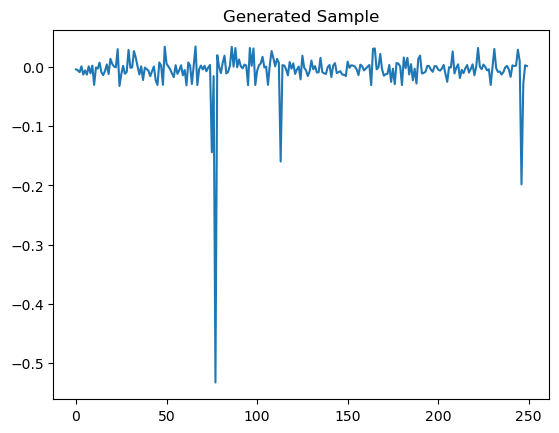

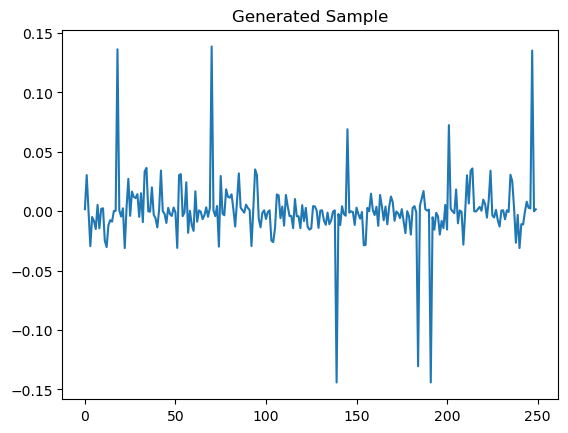

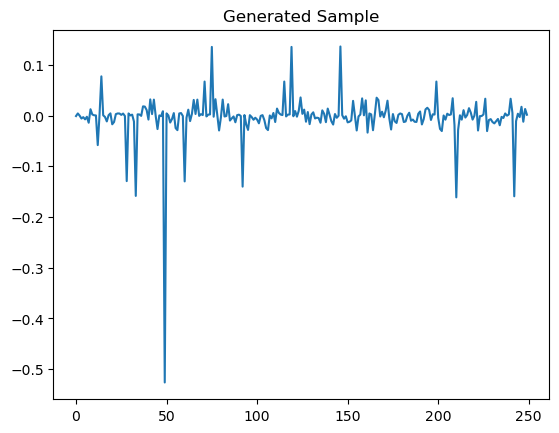

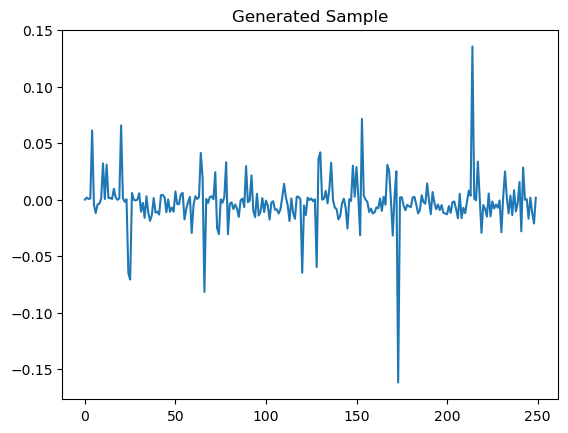

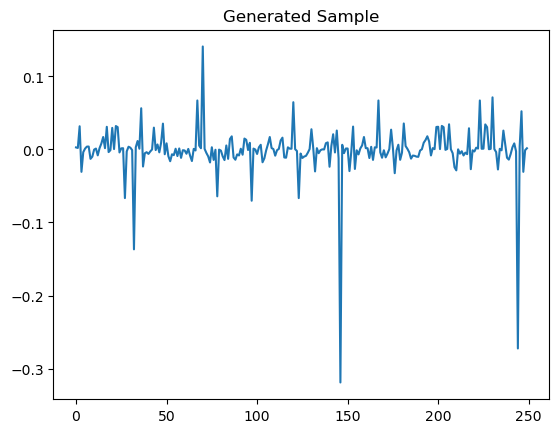

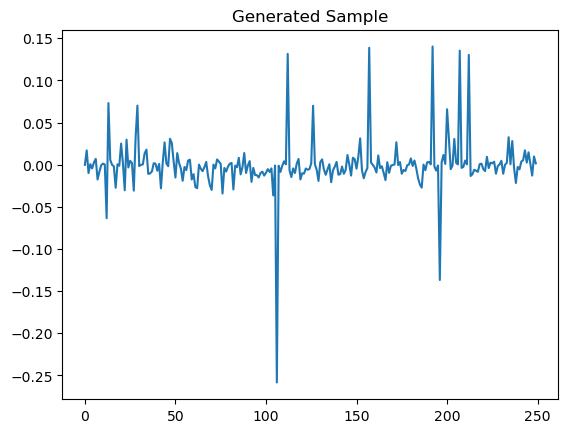

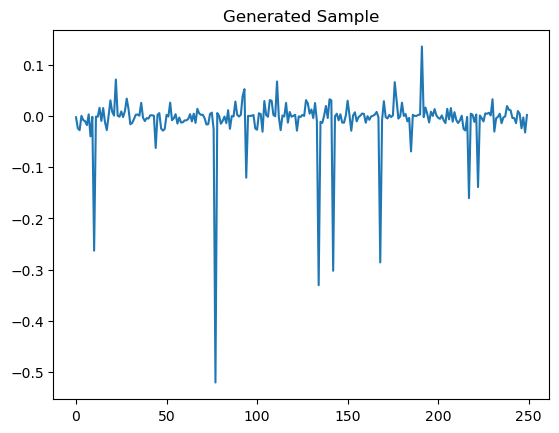

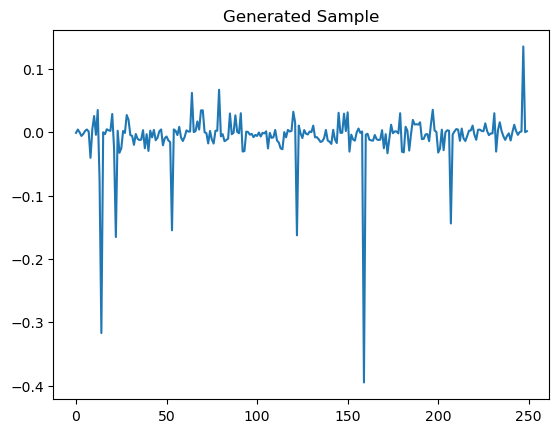

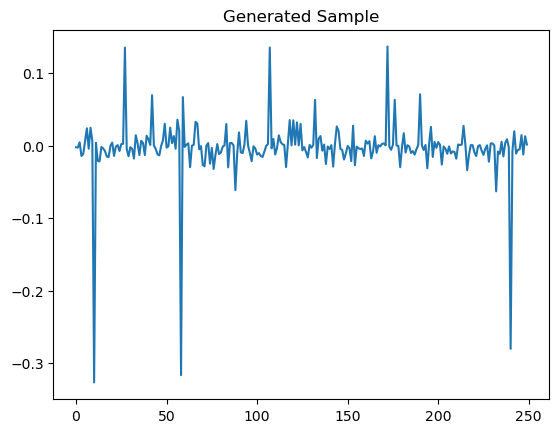

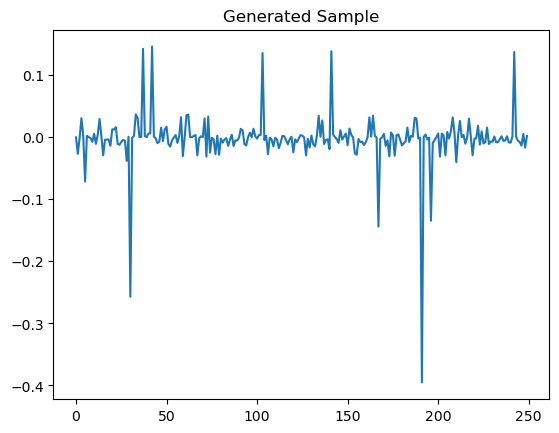

In [432]:
for i in range(batch_sample):

    plt.plot(generated_samples[i])
    plt.title("Generated Sample")

    plt.show()

## Cluster the embeddings

In [152]:
batch= data[0]
print(batch.shape)
batch= np.transpose(batch)
print(batch.shape)
batch= np.expand_dims(batch, axis=2)
print(batch.shape)

(250, 363)
(363, 250)
(363, 250, 1)


In [153]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(batch)
print(encoded_outputs.shape)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
print(flat_enc_outputs.shape)
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
print(f"Shape of the code indices: {codebook_indices.shape}")

12/12 [==============================] - 0s 2ms/step
(363, 62, 16)
(22506, 16)
Shape of the code indices: (22506,)


In [167]:
num_embeddings = embeddings.shape[1]
# Quantization.
encodings = tf.one_hot(codebook_indices, num_embeddings)
print(f'Encodings dim: {encodings.shape}')
quantized = tf.matmul(encodings, embeddings, transpose_b=True)
print(f'Quantized dim: {quantized.shape}')
        # Reshape the quantized values back to the original input shape
quantized = tf.reshape(quantized, encoded_outputs.shape)
print(f'Quantized dim: {quantized.shape}')


Encodings dim: (22506, 128)
Quantized dim: (22506, 16)
Quantized dim: (363, 62, 16)


In [168]:
quantized = np.array(quantized)


In [174]:
quantized = quantized.reshape(quantized.shape[0],-1 )
print(quantized.shape)

(363, 992)


In [183]:
import pickle
with open("companies_362", "rb") as fp:   # Unpickling
   companies = pickle.load(fp)

In [188]:
from scipy.cluster.hierarchy import dendrogram, linkage 

linked = linkage(quantized,  'average', metric='cosine')
plt.figure(figsize=(300,150))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True, labels=companies, leaf_font_size=20)
plt.savefig('cluster.png', format='png', bbox_inches='tight')
plt.savefig('cluster.jpg', format='jpg', bbox_inches='tight')

In [181]:
linked.shape

(362, 4)